<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/%EC%8B%A4%EC%8A%B5_5)_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5%EC%9C%BC%EB%A1%9C_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5(target_%3D_displacement)_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

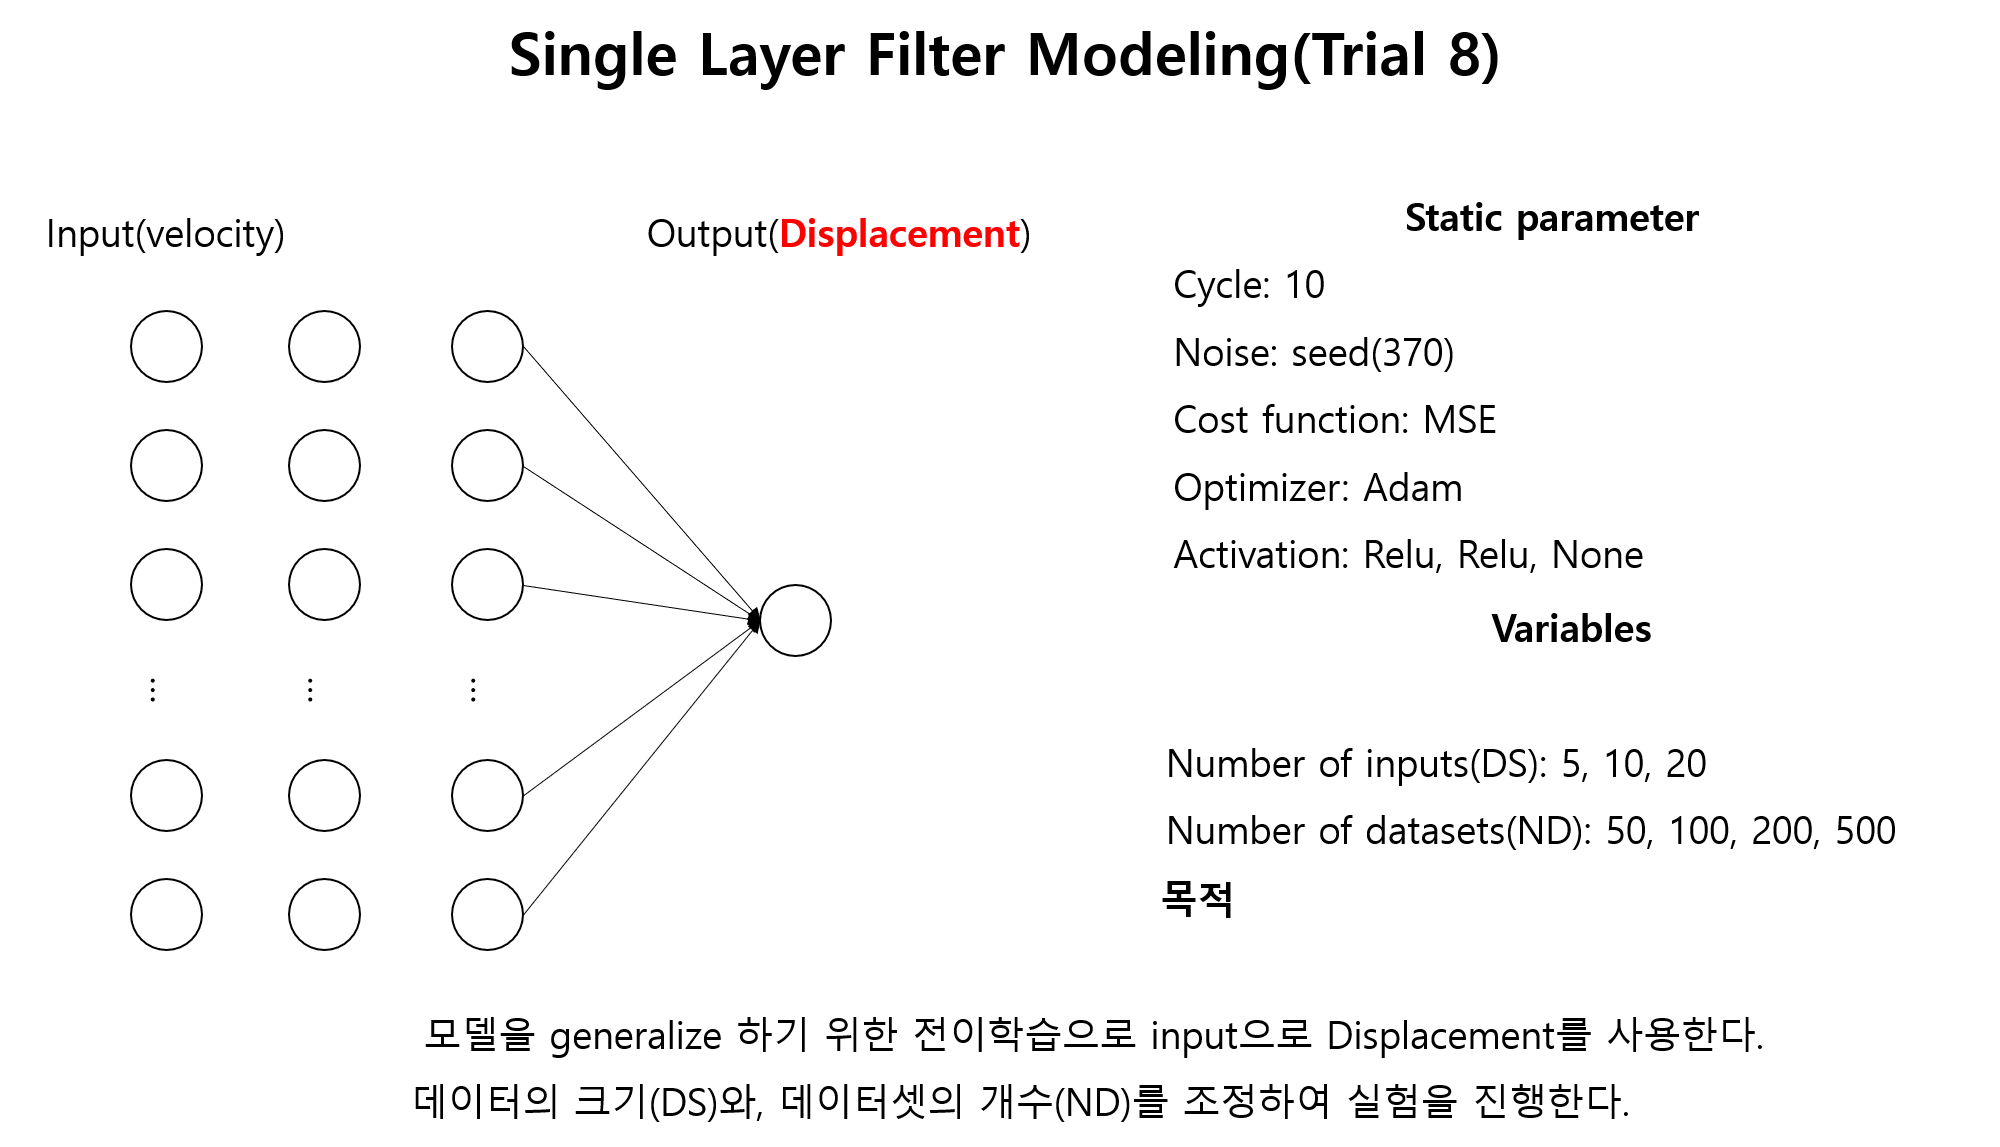

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

#실험 조건, 데이터 사이즈 설정

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))
dx = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping

#정규분포 노이즈 생성
np.random.seed(370)
w = np.random.randn(1,N)
n = np.random.randn(1,N)

# X행렬 구성성분
A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

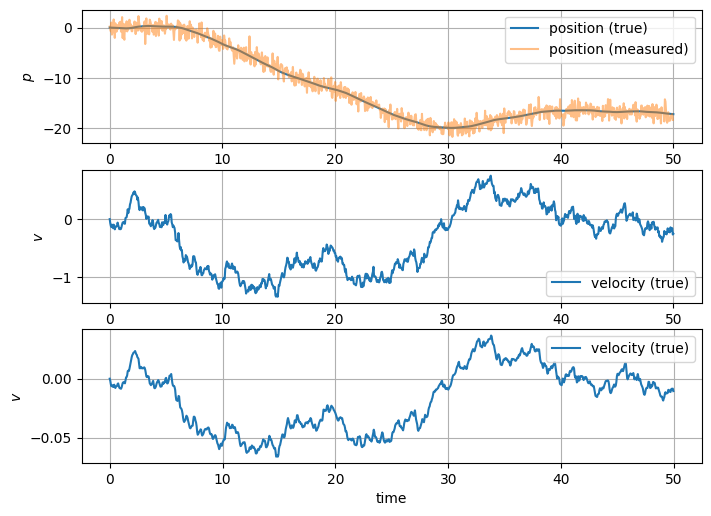

In [37]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])


for t in range(N-1):
    #displacement 추가 
    #현재 변위 = 현재 위치 - 방금 전 위치
    dx[:,t+1] = x[0,t+1] - x[0,t]
    

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(3,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
#displacement는 velocity와 모양이 같다. (속도에 증분을 곱한 것 이므로)
plt.subplot(3,1,3)
plt.plot(ts[:-1],dx[0,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

In [38]:
pos_t = np.zeros((1,1000))
temp_pos_t = np.zeros((1,1000))


for i in range(N-1):
  temp_pos_t[0,i+1]=temp_pos_t[0,i]+dx[0,i]
  pos_t[0,i+1]=temp_pos_t[0,i+1]

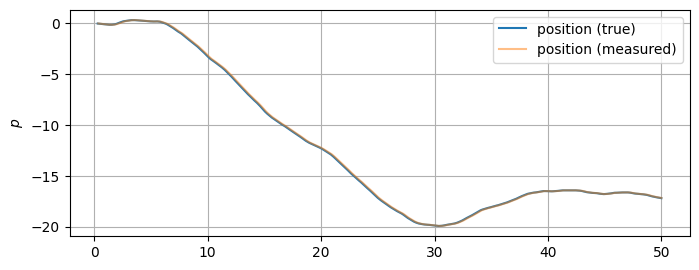

In [39]:
plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos_t[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

In [40]:
DS ,ND = 5, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

In [41]:
train_input.shape, train_target.shape

((50, 5), (50,))

In [42]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model1.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [49]:
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model1.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0380 - mse: 0.0014
              2 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.0034 - mae: 0.0586 - mse: 0.0034
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.0051 - mae: 0.0715 - mse: 0.0051
              4 번째 cycle
1/1 [==============================] - 0s 8ms/step - loss: 0.0061 - mae: 0.0784 - mse: 0.0061
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.0065 - mae: 0.0808 - mse: 0.0065
              6 번째 cycle
1/1 [==============================] - 0s 8ms/step - loss: 0.0064 - mae: 0.0799 - mse: 0.0064
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.0059 - mae: 0.0769 - mse: 0.0059
              8 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.0053 - mae: 0.0725 - mse: 0.0053
              9 번째 cycle
1/1 [==================

In [50]:
input1 = np.zeros((1,DS))
output1 = np.zeros((1,1,DS))

for i in range(1000-DS):
  input1 = y[:,i:DS+i].copy()
  output1=np.append(output1,model1.predict(input1))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


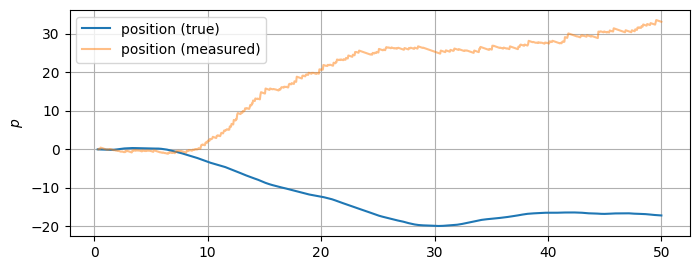

In [51]:
output1 = np.reshape(output1,(1,1000))
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output1[0,i]
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()


ND, DS = 5, 100

====================시작===================

====================모델 생성===================
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.0007054522866383195]
              2 번째 cycle
loss = [0.0011678270529955626]
              3 번째 cycle
loss = [0.001054503140039742]
              4 번째 cycle
loss = [0.0007374700508080423]
              5 번째 cycle
loss = [

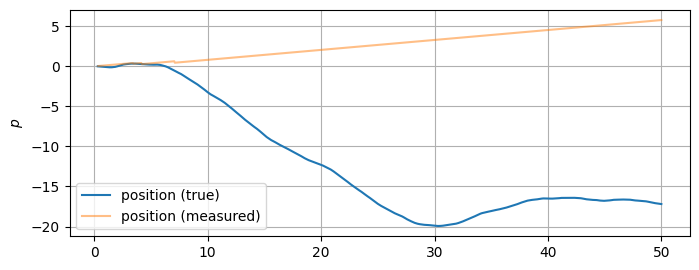

In [59]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model2 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model2.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model2.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model2.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input2 = np.zeros((1,DS))           #num 수정
output2 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input2 = y[:,i:DS+i].copy()       #num 수정
  output2=np.append(output2,model2.predict(input2))       #num 수정
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output2 = np.reshape(output2,(1,1000))        #num 수정
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output2[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 5, 200

====================시작===================

====================모델 생성===================
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [1.1271544694900513]
              2 번째 cycle
loss = [0.227280855178833]
              3 번째 cycle
loss = [0.0632072165608406]
              4 번째 cycle
loss = [0.020755263045430183]
              5 번째 cycle
loss = [0.00778454

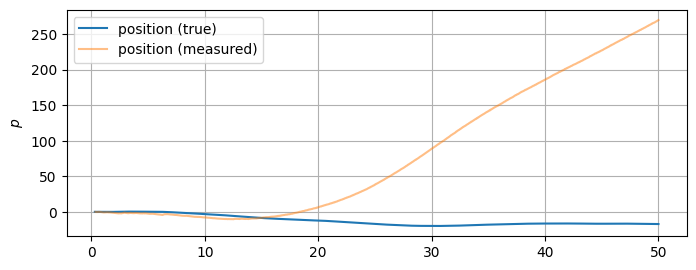

In [60]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 200
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model3 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model3.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model3.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model3.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input3 = np.zeros((1,DS))           #num 수정
output3 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input3 = y[:,i:DS+i].copy()       #num 수정
  output3=np.append(output3,model3.predict(input3))       #num 수정, 4개
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output3 = np.reshape(output3,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output3[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 5, 500

====================시작===================

====================모델 생성===================
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [2.2794032702222466e-05]
              2 번째 cycle
loss = [4.4519842049339786e-05]
              3 번째 cycle
loss = [6.366257002810016e-05]
              4 번째 cycle
loss = [7.651516352780163e-05]
              5 번째 cycle
loss 

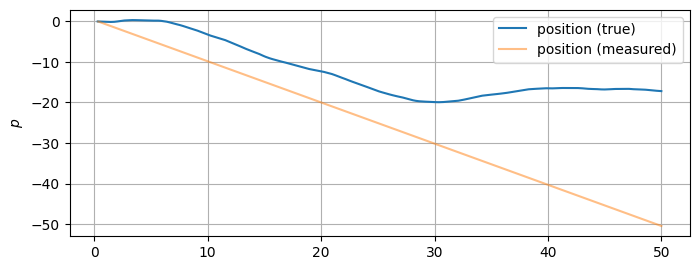

In [61]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model4 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model4.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model4.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model4.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input4 = np.zeros((1,DS))           #num 수정
output4 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input4 = y[:,i:DS+i].copy()       #num 수정
  output4=np.append(output4,model4.predict(input4))       #num 수정
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output4 = np.reshape(output4,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output4[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 50

====================시작===================

====================모델 생성===================
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.30251994729042053]
              2 번째 cycle
loss = [0.1896405965089798]
              3 번째 cycle
loss = [0.13811317086219788]
              4 번째 cycle
loss = [0.1092333272099495]
              5 번째 cycle
loss = [0.09015

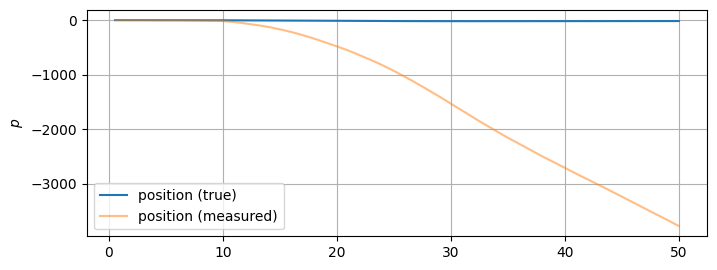

In [62]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model5 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model5.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model5.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model5.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input5 = np.zeros((1,DS))           #num 수정
output5 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input5 = y[:,i:DS+i].copy()       #num 수정
  output5=np.append(output5,model5.predict(input5))       #num 수정, 4개
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output5 = np.reshape(output5,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output5[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 100

====================시작===================

====================모델 생성===================
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.02684437856078148]
              2 번째 cycle
loss = [0.014444606378674507]
              3 번째 cycle
loss = [0.010118615813553333]
              4 번째 cycle
loss = [0.007034385576844215]
              5 번째 cycle
loss = [0.

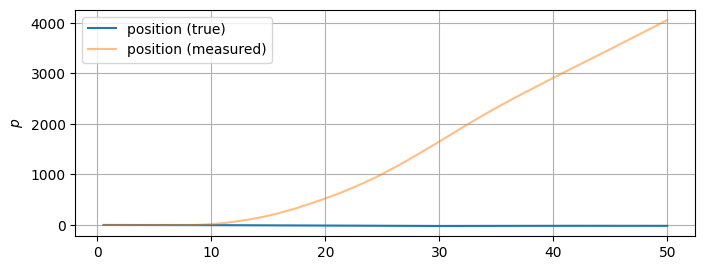

In [63]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model6 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model6.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model6.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model6.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input6 = np.zeros((1,DS))           #num 수정
output6 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input6 = y[:,i:DS+i].copy()       #num 수정
  output6=np.append(output6,model6.predict(input6))       #num 수정, 4개
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output6 = np.reshape(output6,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output6[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 200

====================시작===================

====================모델 생성===================
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.0085264528170228]
              2 번째 cycle
loss = [0.00019134367175865918]
              3 번째 cycle
loss = [0.000315553683321923]
              4 번째 cycle
loss = [0.0007134752231650054]
              5 번째 cycle
loss = [

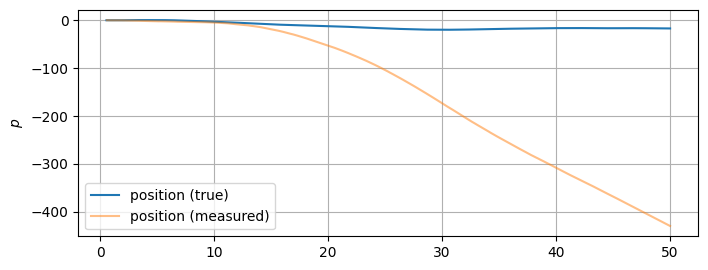

In [64]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 200
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model7 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model7.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model7.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model7.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input7 = np.zeros((1,DS))           #num 수정
output7 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input7 = y[:,i:DS+i].copy()       #num 수정
  output7=np.append(output7,model7.predict(input7))       #num 수정, 4개
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output7 = np.reshape(output7,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output7[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 500

====================시작===================

====================모델 생성===================
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습==========

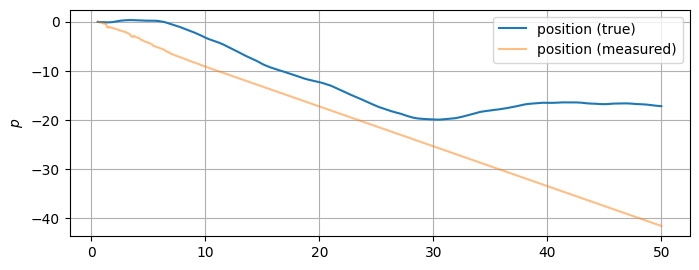

In [67]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model8 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
  ])
model8.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model8.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model8.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])
      

#포지션 입력
input8 = np.zeros((1,DS))           #num 수정
output8 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input8 = y[:,i:DS+i].copy()       #num 수정
  output8=np.append(output8,model8.predict(input8))       #num 수정, 4개
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output8 = np.reshape(output8,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))



for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output8[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 20, 50

====================시작===================

====================모델 생성===================
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_62 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.007188886404037476]
              2 번째 cycle
loss = [0.0042692869901657104]
              3 번째 cycle
loss = [0.004605199210345745]
              4 번째 cycle
loss = [0.00022282727877609432]
              5 번째 cycle
loss =

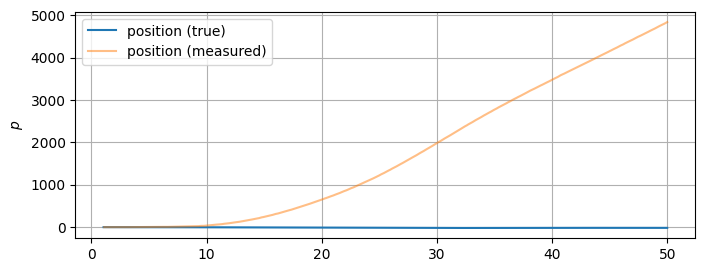

In [70]:
#데이터 입력
print("====================시작===================")
DS ,ND = 20, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model9 = tf.keras.models.Sequential([       #num 수정
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model9.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])       #num 수정

model9.summary()        #num 수정


#학습
print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model9.fit(input, target,epochs = 1, verbose = 0) #num 수정
    if i==ND-1:
      print("loss =", hist.history['loss'])

#포지션 입력
input9 = np.zeros((1,DS))           #num 수정
output9 = np.zeros((1,1,DS))        #num 수정

print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input9 = y[:,i:DS+i].copy()       #num 수정
  output9=np.append(output9,model9.predict(input9))       #num 수정, 4개
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output9 = np.reshape(output9,(1,1000))        #num 수정, 2개
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output9[0,i]        #num 수정
  pos[0,i+1]=temp_pos[0,i+1]
  

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



relu 3층으로 학습하는건 더이상 소용없어보인다...

ND, DS = 20, 100

ND, DS = 20, 200

ND, DS = 20, 500